Import Libraries

In [2]:
import tensorflow as tf
import tensorflow_text
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


Part 1:

In [3]:
def load_dataset():
  dataset, _ = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,shuffle_files=True,as_supervised=True)
  train_data, validation_data , test_data = dataset['train'], dataset['validation'], dataset['test']
  return train_data, validation_data , test_data 

In [5]:
def load_bert_tokenizer():
  tf.keras.utils.get_file('ted_hrlr_translate_pt_en_converter.zip','https://storage.googleapis.com/download.tensorflow.org/models/ted_hrlr_translate_pt_en_converter.zip',cache_dir='.', cache_subdir='', extract=True)
  tokenizers = tf.saved_model.load("ted_hrlr_translate_pt_en_converter")
  return tokenizers

In [110]:
def pair_english_and_portegal(portegal, english):
    portegal_tokens = tokenizers.pt.tokenize(portegal).to_tensor()
    english_tokens = tokenizers.en.tokenize(english).to_tensor()
    return portegal_tokens, english_tokens

In [111]:
def remove_large_sentenses(portegal, english):
  shape_portegal = tf.shape(portegal)[1]
  shape_english = tf.shape(english)[1]
  if  shape_portegal < 140 and shape_english<140:
    is_a_short_message =True
  else :
    is_a_short_message =False
  return is_a_short_message

In [112]:
train_data, validation_data , test_data  = load_dataset()
tokenizers = load_bert_tokenizer()
train_batches = train_data.cache().shuffle(10000).batch(64).map(pair_english_and_portegal, num_parallel_calls=tf.data.AUTOTUNE).filter(remove_large_sentenses).prefetch(tf.data.AUTOTUNE)
val_batches = validation_data.cache().shuffle(10000).batch(64).map(pair_english_and_portegal, num_parallel_calls=tf.data.AUTOTUNE).filter(remove_large_sentenses).prefetch(tf.data.AUTOTUNE)
test_batches = test_data.cache().shuffle(10000).batch(64).map(pair_english_and_portegal, num_parallel_calls=tf.data.AUTOTUNE).filter(remove_large_sentenses).prefetch(tf.data.AUTOTUNE)

Part 2:

In [113]:
def positional_encoding(pos, d):
  power =  (2 * (np.arange(d)[np.newaxis, :]//2)) / np.float32(d)
  PE = np.arange(pos)[:, np.newaxis] * ( 1 / np.power(10000,power))
  PE[:, 0::2] = np.sin(PE[:, 0::2])
  PE[:, 1::2] = np.cos(PE[:, 1::2])
  output = tf.cast(PE[np.newaxis, ...], dtype=tf.float32)
  return output

Part 3:

In [13]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :] 

In [14]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask 

In [15]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True) 
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
  output = tf.matmul(attention_weights, v)
  return output, attention_weights

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d = d
    self.depth = d // self.num_heads
    self.wq = tf.keras.layers.Dense(d)
    self.wk = tf.keras.layers.Dense(d)
    self.wv = tf.keras.layers.Dense(d)
    self.dense = tf.keras.layers.Dense(d)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    q = self.wq(q) 
    k = self.wk(k)
    v = self.wv(v)
    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  
    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d))
    output = self.dense(concat_attention)

    return output, attention_weights

In [17]:
def point_wise_feed_forward_network(d_model, dff):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), 
      tf.keras.layers.Dense(d_model) 
  ])
  return model

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()
    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output) 
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

In [19]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    out1 = self.layernorm1(attn1 + x)
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask) 
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1) 
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [20]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(140, self.d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x

In [21]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(140, d_model)
    self.dec_layers = [ DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
    seq_len = tf.shape(x)[1]
    attention_weights = {}
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)
      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2
    return x, attention_weights

In [22]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    inp, tar = inputs
    padding_mask, look_ahead_mask = self.create_masks(inp, tar)
    enc_output = self.encoder(inp, training, padding_mask)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)
    final_output = self.final_layer(dec_output)
    return final_output, attention_weights

  def create_masks(self, inp, tar):
    padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return padding_mask, look_ahead_mask

In [27]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)
  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [103]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
validation_loss = tf.keras.metrics.Mean(name='validation_loss_loss')
validation_accuracy = tf.keras.metrics.Mean(name='validation_loss_accuracy')

optimizer = tf.keras.optimizers.Adam(0.05, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
transformer = Transformer(num_layers=5,d_model=128,num_heads=8,dff=512,input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),target_vocab_size=tokenizers.en.get_vocab_size().numpy(),rate=0.1)

In [122]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],training = True)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(35):
  train_loss.reset_states()
  train_accuracy.reset_states()
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)
  print("Epoch = " + str(epoch + 1) + "- loss = " + str(train_loss.result().numpy()) + " accuracy = " + str( train_accuracy.result().numpy()))

In [124]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=140):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]
    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)
      predictions = predictions[:, -1:, :]  
      predicted_id = tf.argmax(predictions, axis=-1)
      output_array = output_array.write(i+1, predicted_id[0])
      if predicted_id == end:
        break
    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]
    tokens = tokenizers.en.lookup(output)[0]
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)
    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [125]:
examples = []
for pt_examples, en_examples in validation_data.batch(20).take(1):
  for i in range(len(pt_examples.numpy())):
    pt = pt_examples.numpy()[i].decode('utf-8')
    en = en_examples.numpy()[i].decode('utf-8')
    example = [pt,en]
    examples.append(example)


In [ ]:
for data in examples:
  translated_text, translated_tokens, attention_weights = Translator(tokenizers, transformer , tf.constant(data[0]))
  print( "Input Data     = " + str(data[0]))
  print("model Translate = " + str(translated_text.numpy().decode("utf-8")))
  print( "real Translate = " + str(data[1]))
  print("-------------------------------------------")

In [114]:
def show_heads(sentence, translated_tokens,heads):
  fig = plt.figure(figsize=(25, 12))
  token = tokenizers.pt.lookup(tokenizers.pt.tokenize(tf.convert_to_tensor([sentence])).to_tensor())[0] 
  for h, head in enumerate(heads):
    ax = fig.add_subplot(2, 4, h+1)
    ax = plt.gca()
    ax.matshow(head)
    ax.set_xticks(range(len(token)))
    ax.set_yticks(range(len(translated_tokens)))
    labels = [label.decode('utf-8') for label in token.numpy()]
    ax.set_xticklabels(labels, rotation=90)
    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)
    ax.set_xlabel(f'Head {h+1}')
  plt.tight_layout()
  plt.show()

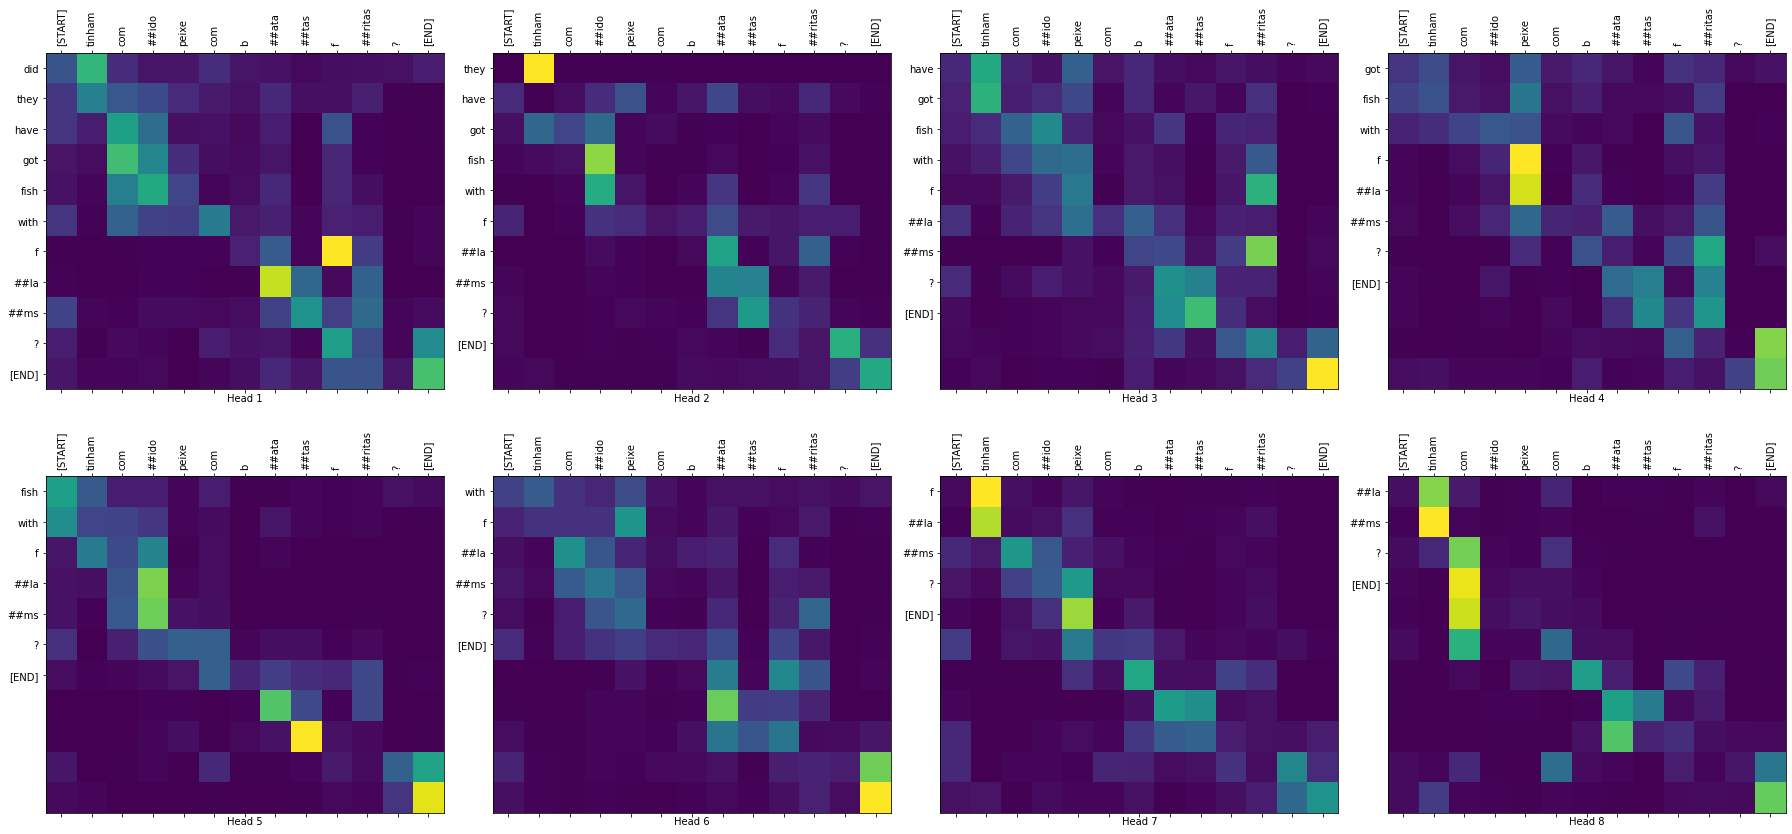

In [115]:
data = examples[0]
translated_text, translated_tokens, attention_weights = translator(tf.constant(data[0]))
show_heads(data[0], translated_tokens[1:],attention_weights['decoder_layer4_block2'][0])